# Kp vsys likelyhood map
(Base on "Noisy Likelihoods" example from dynesty)

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(819)

In [27]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 20})



In [3]:
import dynesty

# Generate logl fct by interpolating kp-vsys map

In [4]:
from scipy.interpolate import RegularGridInterpolator

In [5]:
zfile = np.load('/home/ldang05/scratch/dynasty_maps/logl_map_detailed_CoRoT_2b.npz')

In [6]:
kp = zfile['kp']
vsys = zfile['vsys']
logl_map = zfile['logl_map'] + 9e6  # The logl was artificially shifted. Unshift it

print("vsys shape:", vsys.shape)
print("kp shape:", kp.shape)
print("logl_map shape:", logl_map.shape)

logl_map = np.sum(logl_map, axis=(-1, -2))
print("sumed logl_map shape:", logl_map.shape)


vsys shape: (400, 400)
kp shape: (400, 400)
logl_map shape: (400, 400, 51, 53)
sumed logl_map shape: (400, 400)


In [7]:
logl_map_fct = RegularGridInterpolator([vsys[:, 0], kp[0, :]], logl_map, method='cubic')

In [8]:
def loglikelihood(theta):
    return logl_map_fct(theta)[0]

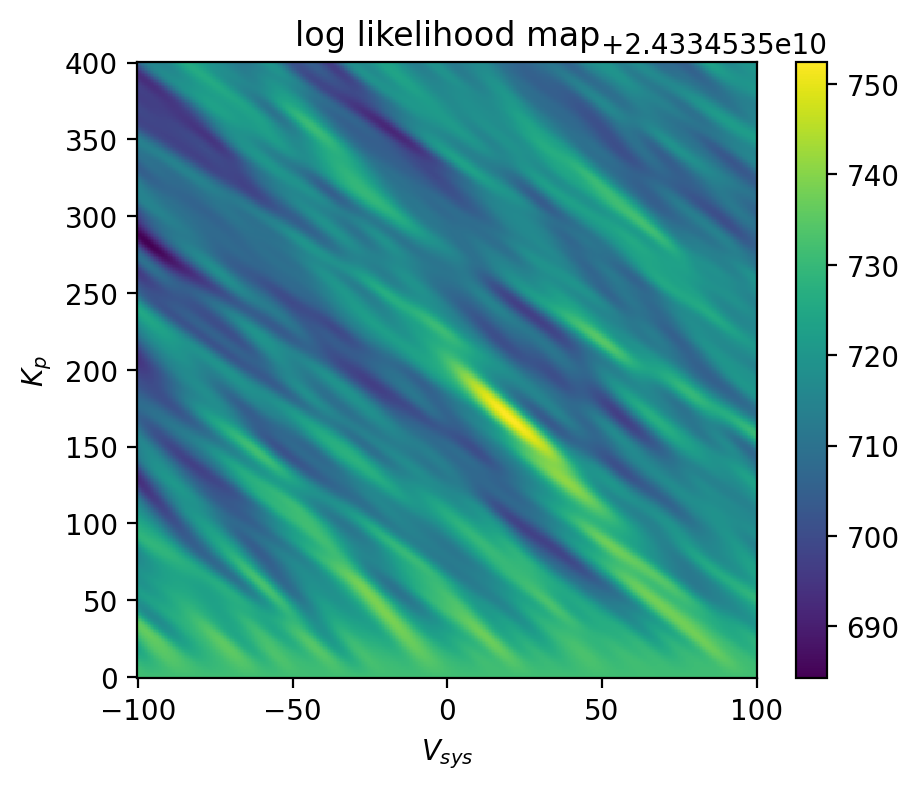

In [14]:
plt.subplots(figsize=(5,4),dpi=200)
plt.pcolormesh(vsys, kp, logl_map)
plt.title("log likelihood map")
plt.xlabel(r'$V_{sys}$')
plt.ylabel("$K_p$")
plt.colorbar()

In [15]:
kp_range = (0., 400.)
vsys_range = (-100., 100.)

In [16]:
# Define our uniform prior.
def uniform_prior(val, low, high):

    out = (high - low) * val + low

    return out

def prior_transform(unif_samples):
    """Transforms samples from the unit cube to the parameter space"""

    v_sys, Kp = unif_samples
    # --- Kp
    Kp_low, Kp_high = kp_range
    Kp = uniform_prior(Kp, Kp_low, Kp_high)

    # --- v_sys
    v_sys_low, v_sys_high = vsys_range
    v_sys = uniform_prior(v_sys, v_sys_low, v_sys_high)

    return np.array([v_sys, Kp]).T

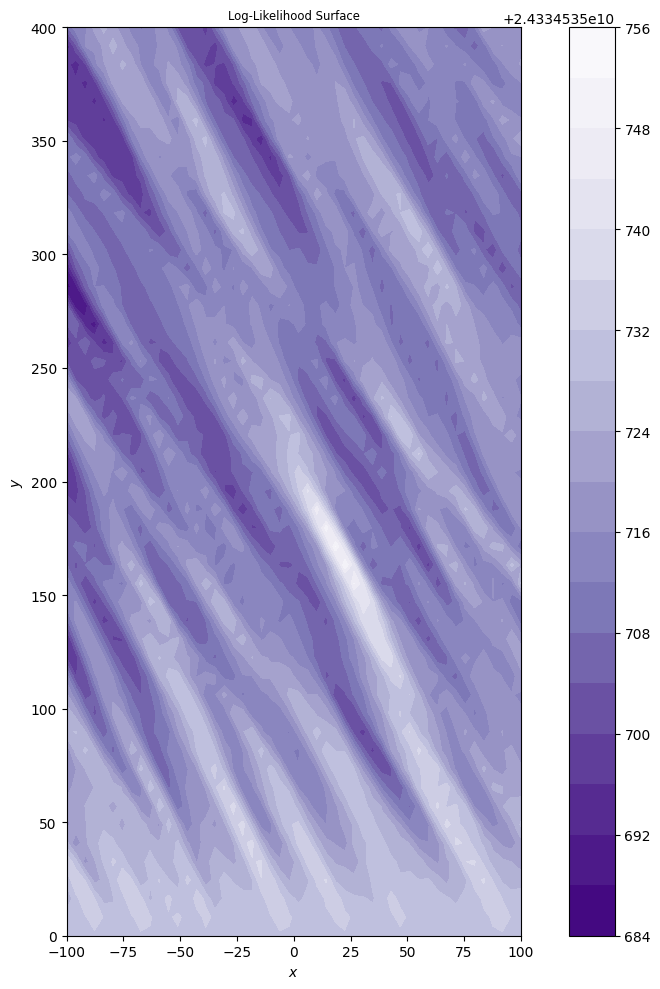

In [17]:
# plot the log-likelihood surface
plt.figure(figsize=(10., 10.))
axes = plt.axes(aspect=1)
xx, yy = np.meshgrid(np.linspace(*vsys_range, 50),
                     np.linspace(*kp_range, 50))
L = np.reshape(list(map(loglikelihood, np.array([xx.ravel(), yy.ravel()]).T)), xx.shape)
im = axes.contourf(xx, yy, L, 20, cmap=plt.cm.Purples_r)
plt.colorbar(im)
plt.title('Log-Likelihood Surface', fontsize='small')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.tight_layout()

## Nested sampling

Let's now sample from our noisy distribution.

In [18]:
import dynesty.pool as dypool

In [19]:
%%time
with dypool.Pool(4, loglike=loglikelihood, prior_transform=prior_transform) as pool:
    dsampler = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, ndim=2,
                                        bound='balls', sample='unif', rstate=rstate, pool=pool)
    dsampler.run_nested(dlogz_init=0.01, nlive_init=500, nlive_batch=500,
                    wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0})

iter: 15099 | batch: 8 | bound: 3 | nc: 1 | ncall: 35465 | eff(%): 42.471 | loglstar: 24334535748.202 < 24334535752.439 < 24334535751.965 | logz: 24334535744.516 +/- 540.587 | stop:  0.914          

CPU times: user 45.7 s, sys: 3.76 s, total: 49.5 s
Wall time: 1min 52s


In [20]:
dres = dsampler.results

In [21]:
%%time
with dypool.Pool(4, loglike=loglikelihood, prior_transform=prior_transform) as pool:
    dsampler2 = dynesty.DynamicNestedSampler(pool.loglike, pool.prior_transform, ndim=2,
                                        bound='multi', sample='unif', rstate=rstate, pool=pool)
    dsampler2.run_nested(dlogz_init=0.01, nlive_init=500, nlive_batch=500,
                    wt_kwargs={'pfrac': 1.0}, stop_kwargs={'pfrac': 1.0})

iter: 15658 | batch: 8 | bound: 3 | nc: 1 | ncall: 45359 | eff(%): 34.486 | loglstar: 24334535748.185 < 24334535752.439 < 24334535752.024 | logz: 24334535744.304 +/- 141.702 | stop:  0.885          

CPU times: user 36.7 s, sys: 4.34 s, total: 41 s
Wall time: 2min 8s


In [22]:
dres2 = dsampler2.results

As expected, sampling is substantially more inefficient in the noisy case since more likelihood calls are required to get a noisy realization that is "better" than the previous noisy realization.

## Comparing Results

Comparing the two results, we see that the noise in our model appears to give a larger estimate for the evidence. This is what we'd expect given that our sampling will preferentially be biased to noisy realizations with larger-than-expected log-likelihoods at any given position.

/home/ldang05/venv/ss-env/lib/python3.9/site-packages/dynesty/utils.py:1033: UserWarning: Weights do not sum to 1 and have been renormalized.
  warnings.warn("Weights do not sum to 1 and have been renormalized.")


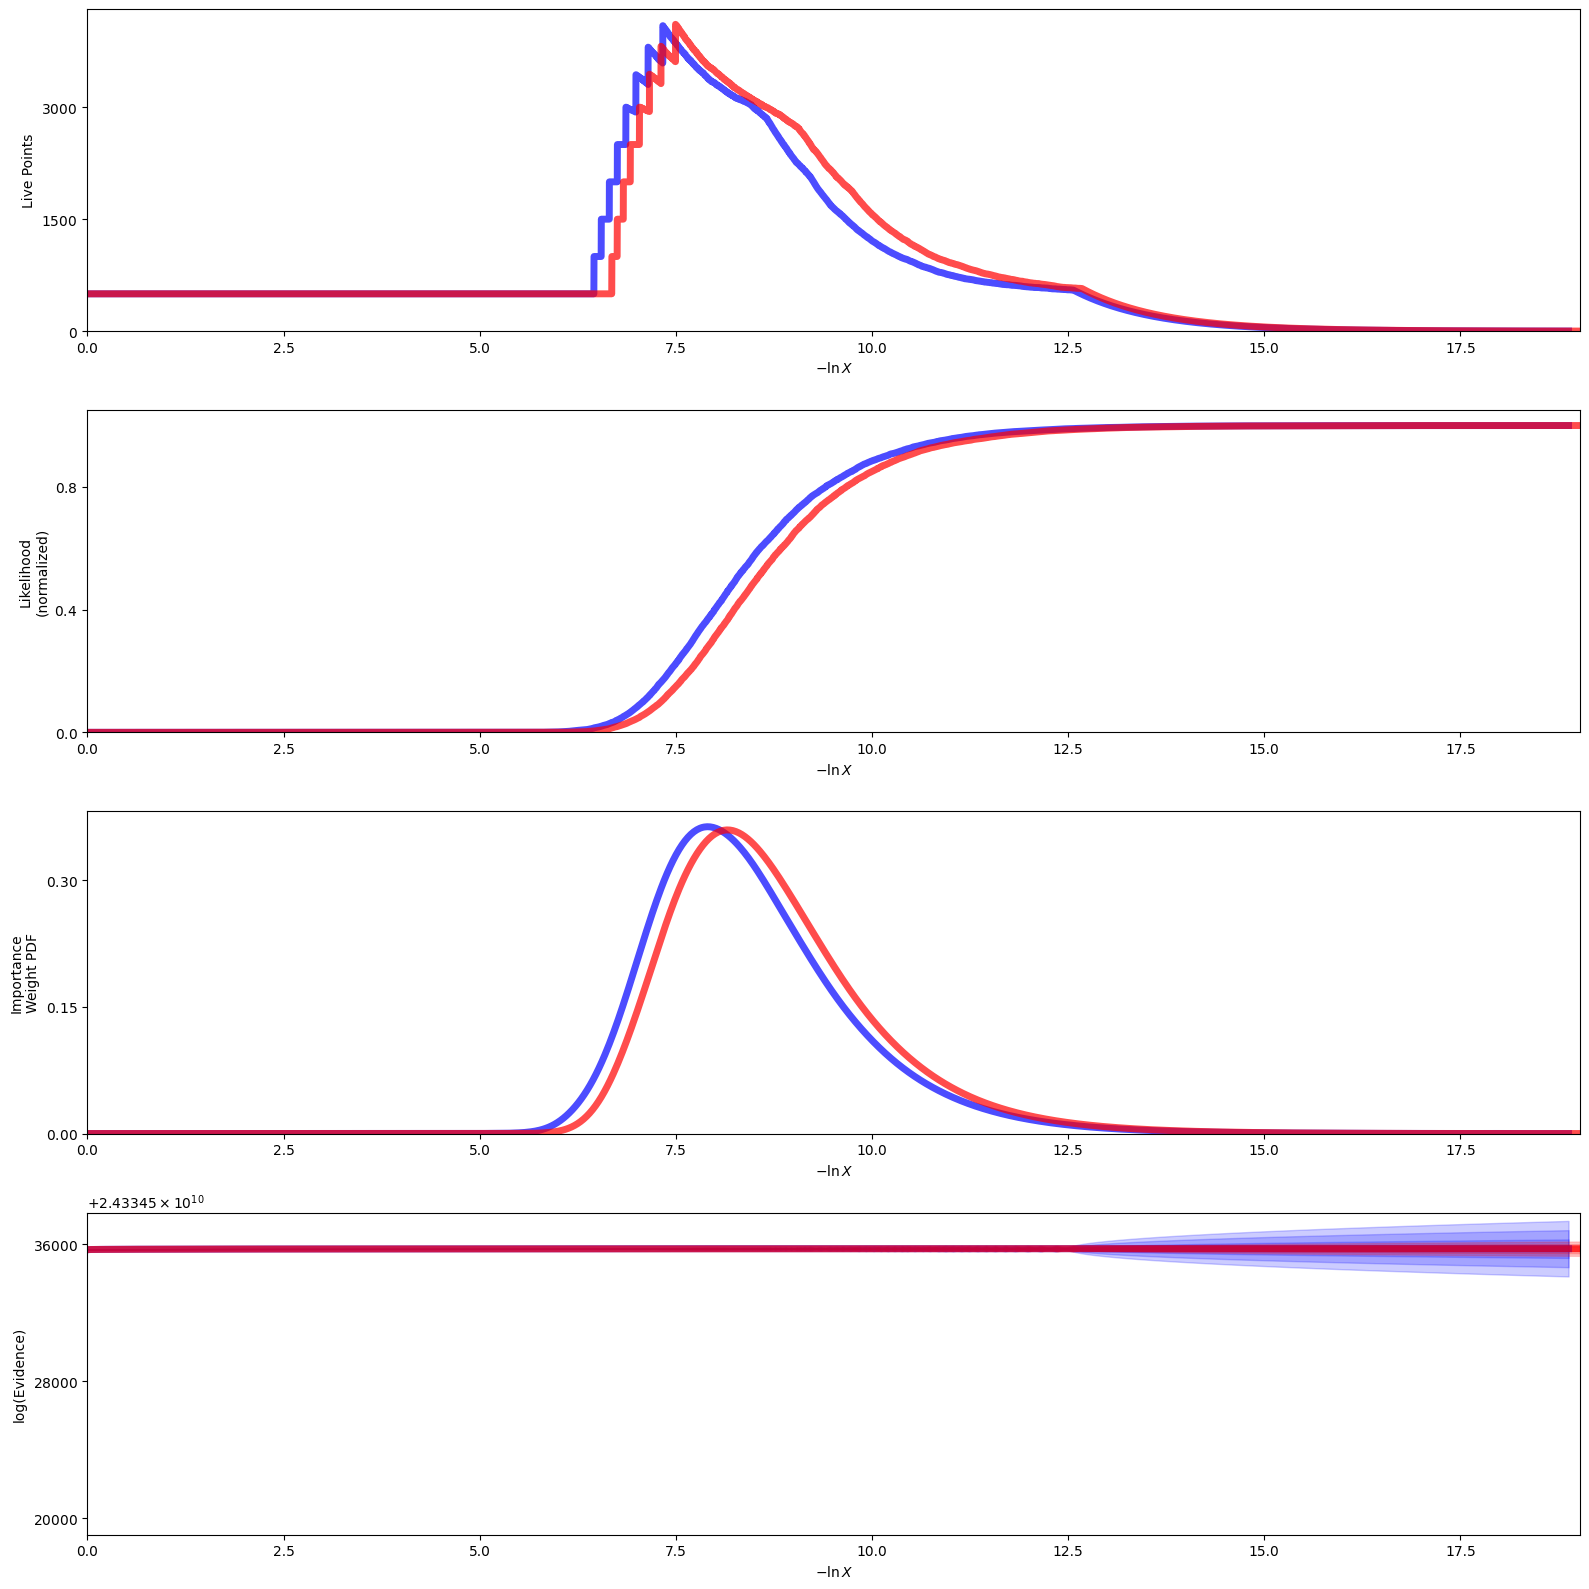

In [23]:
# plot results
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(dres, logplot=True, color='blue', )  # noiseless
fig, axes = dyplot.runplot(dres2, logplot=True, color='red', fig=(fig, axes))
fig.tight_layout()

This effect also propagates through to our posteriors, broadening them relative to the underlying distribution.

(90.0, 240.0)

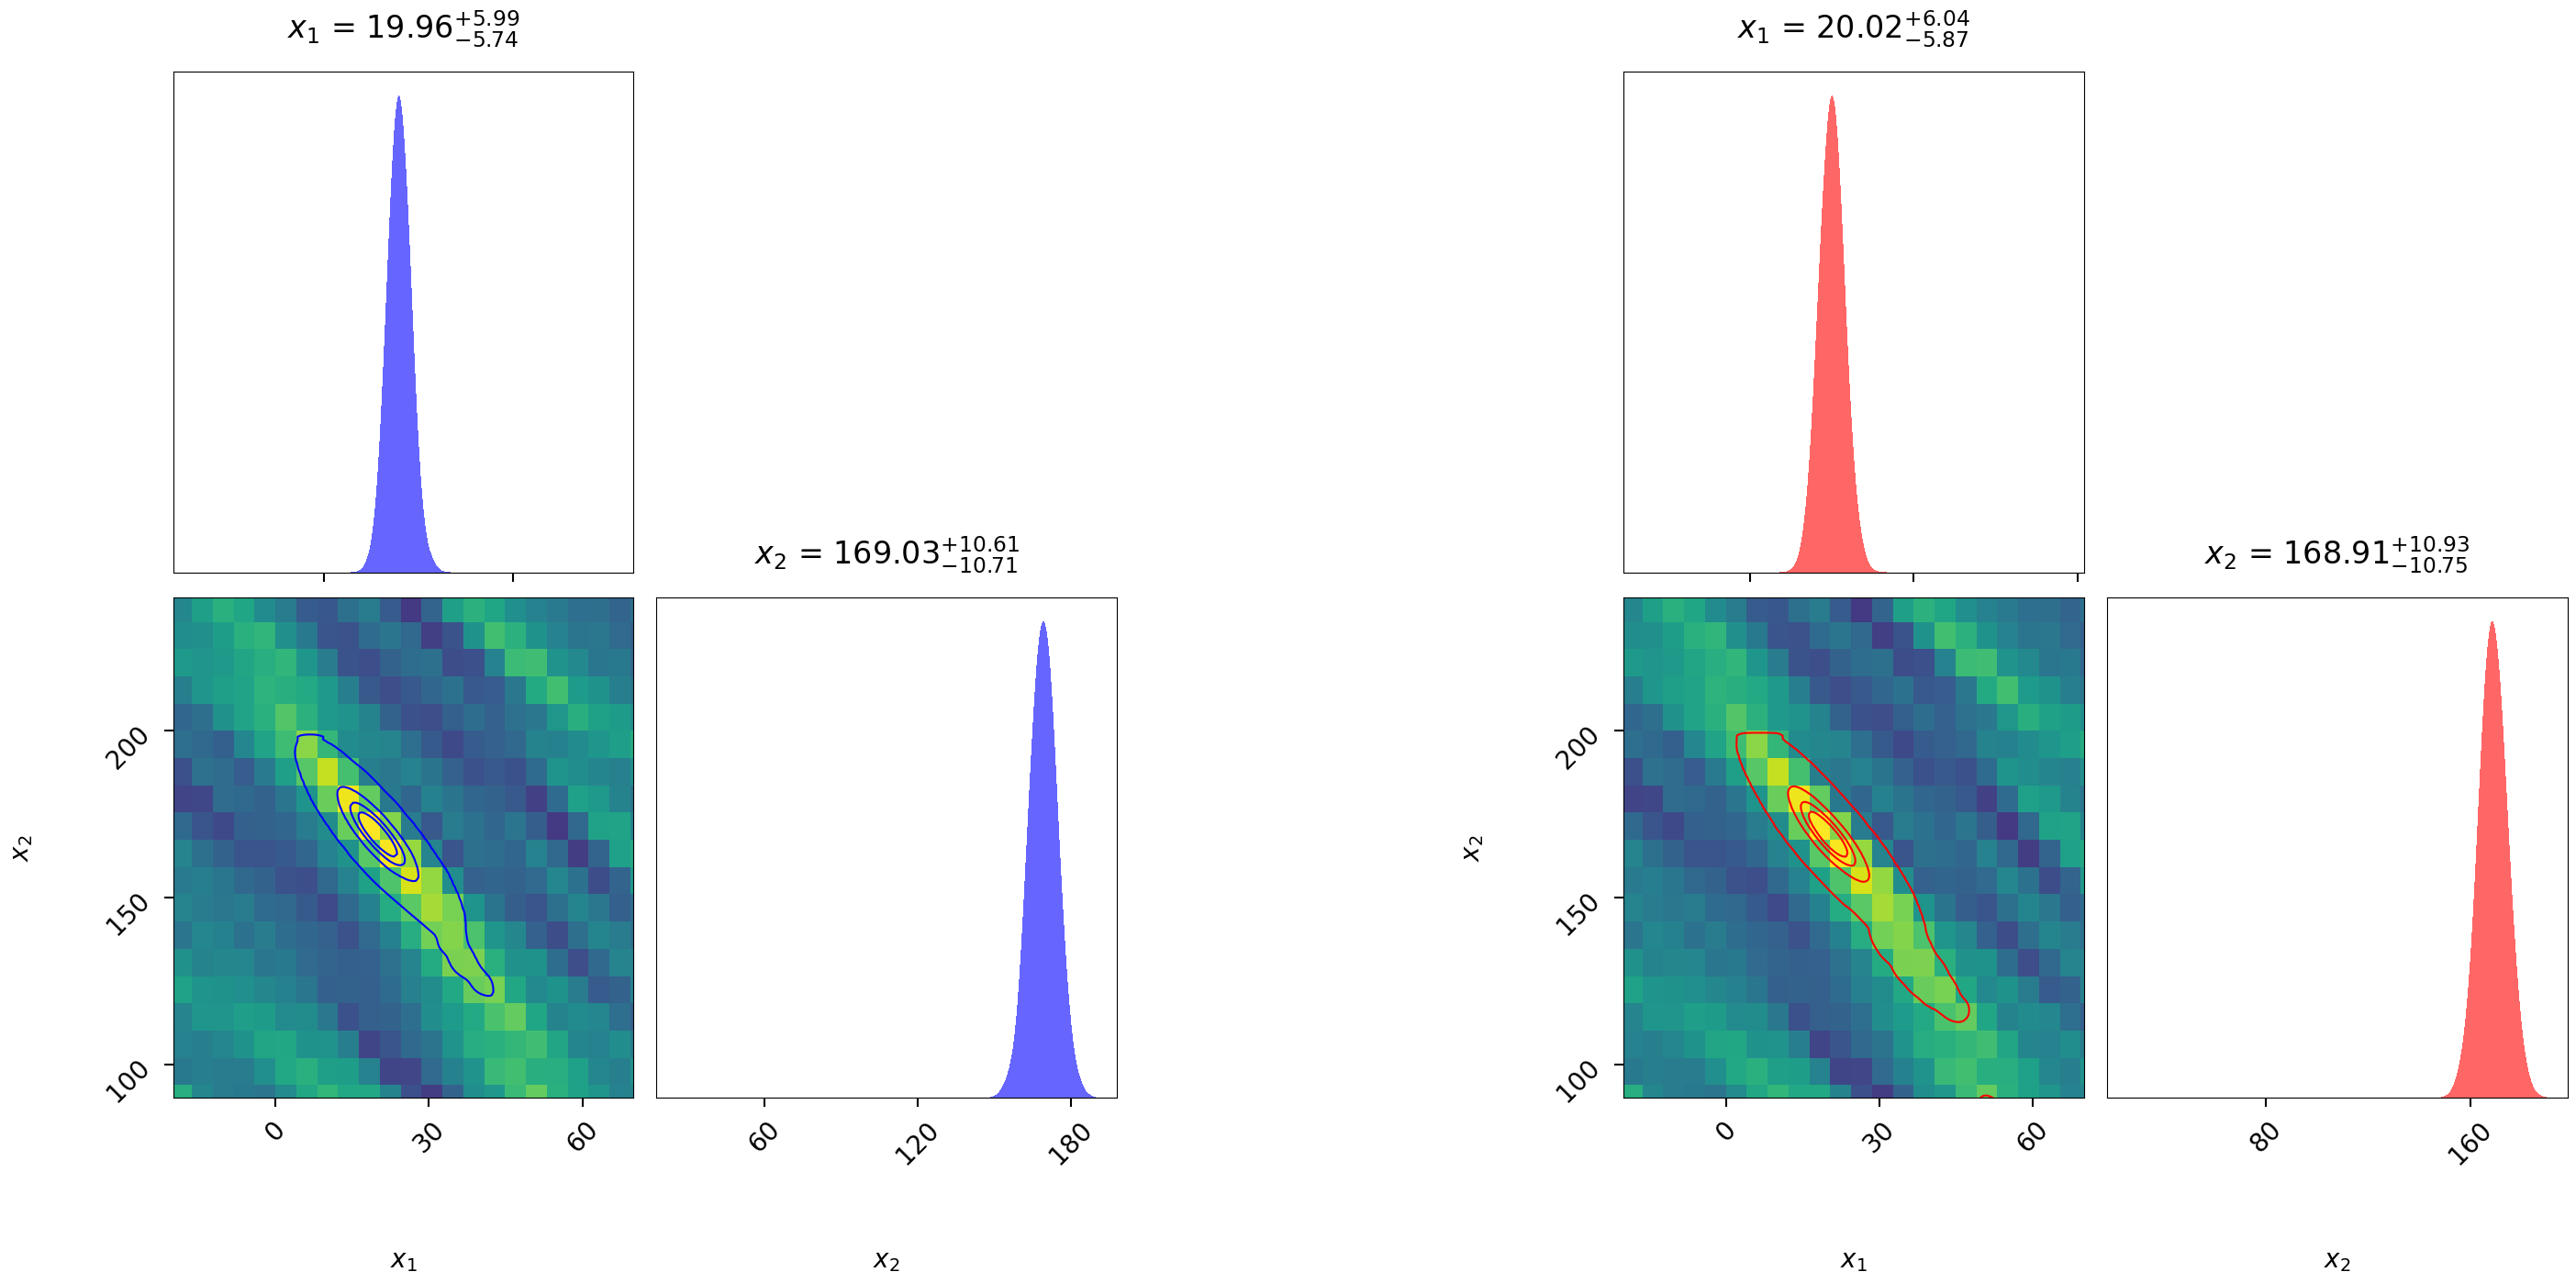

In [28]:
# initialize figure
fig, axes = plt.subplots(2, 5, figsize=(35, 15))
axes = axes.reshape((2, 5))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]

# plot noiseless run (left)
# fg, ax = dyplot.cornerplot(dres, color='blue', truths=[0., 225.], truth_color='black', smooth=0.01,
#                            show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05}, quantiles_2d=[0.5, 0.75, 0.95, 0.99999],
#                            quantiles=None, fig=(fig, axes[:, :2]))
fg, ax = dyplot.cornerplot(dres, color='blue', smooth=0.01,
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05}, quantiles_2d=[0.5, 0.75, 0.95, 0.99999],
                           quantiles=None, fig=(fig, axes[:, :2]))
ax[1][0].pcolormesh(xx, yy, L)
# ax[1][0].set_xlim(-25,25)
ax[1][0].set_xlim(-20,70)
ax[1][0].set_ylim(90,240)

# plot noisy run (right)
fg, ax = dyplot.cornerplot(dres2, color='red', smooth=0.01,
                           show_titles=True, title_kwargs={'y': 1.05},quantiles_2d=[0.5, 0.75, 0.95, 0.999999],
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 3:]))

ax[1][0].pcolormesh(xx, yy, L)
# ax[1][0].set_xlim(-25,25)
ax[1][0].set_xlim(-20,70)
ax[1][0].set_ylim(90,240)

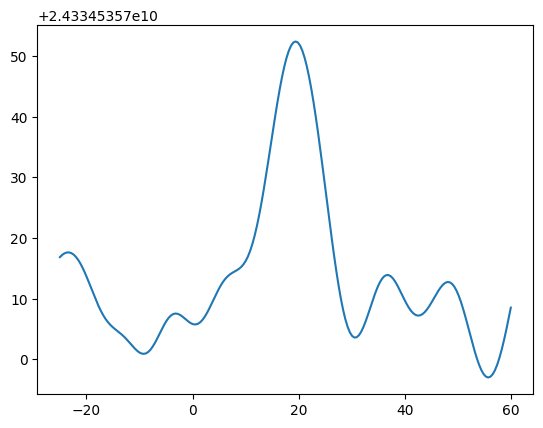

In [25]:
vsys_plot = np.linspace(-25, 60, 200)
plt.plot(vsys_plot, logl_map_fct(np.array([vsys_plot, np.full_like(vsys_plot, 170.)]).T))

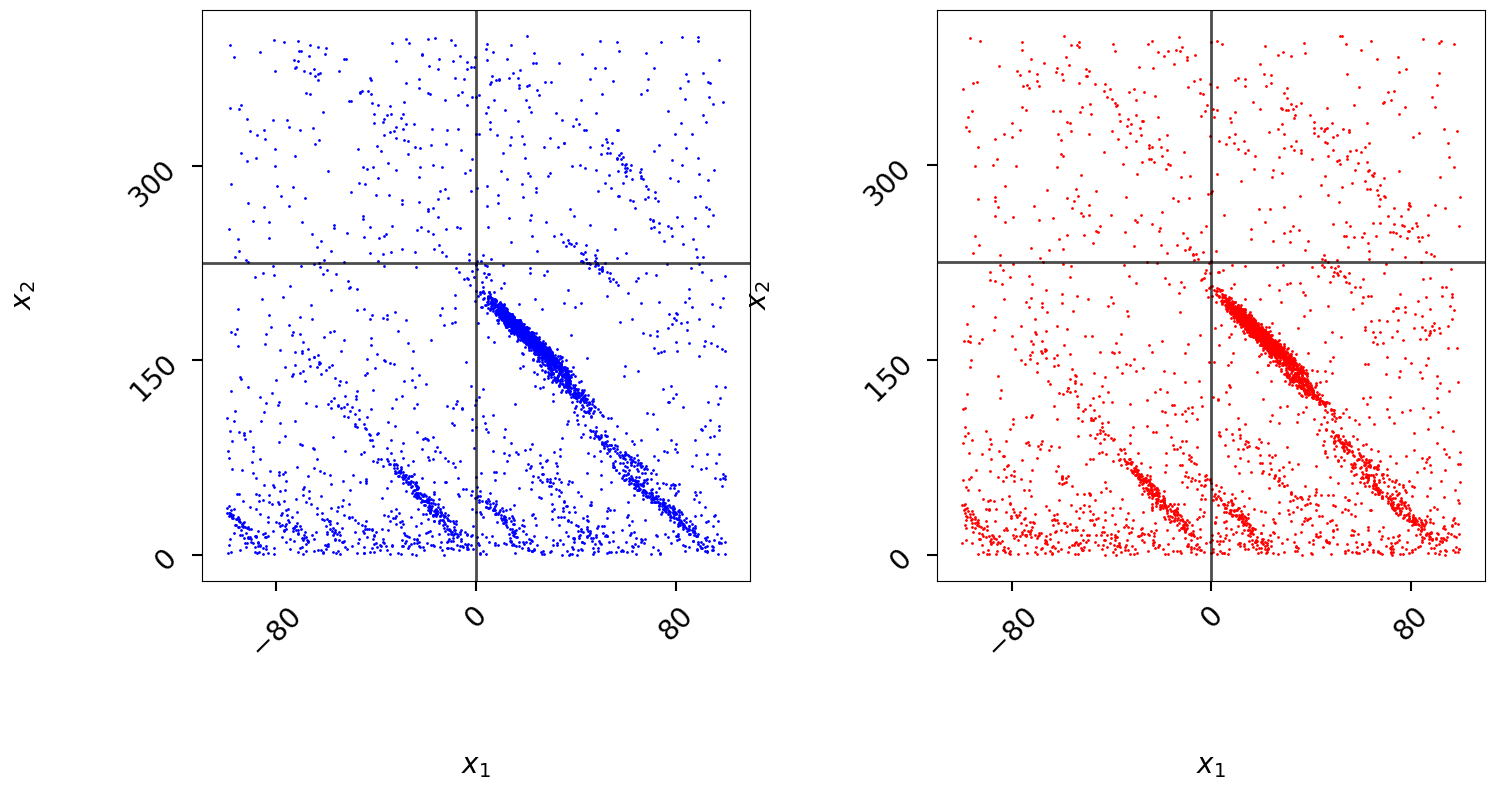

In [31]:
# initialize figure
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

fg, ax = dyplot.cornerpoints(dres, cmap='viridis', kde=False, color='blue', truths=[0., 225.], truth_color='black',
                           max_n_ticks=3, fig=(fig, axes[0]))

fg, ax = dyplot.cornerpoints(dres2, kde=False, color='red', truths=[0., 225.], truth_color='black', max_n_ticks=3, fig=(fig, axes[1]))

# # plot realization of reweighted run (right)
# logl_t = rstate.normal(logls_est, logls_std)
# dres2_rwt2 = dynesty.utils.reweight_run(dres2, logp_new=logl_t)
# fg, ax = dyplot.cornerpoints(dres2_rwt2, color='red', truths=[0., 0.], truth_color='black', max_n_ticks=3, fig=(fig, axes[1]))
plt.tight_layout()

# Forget what's below

## Full Analysis

In general, however, we don't have access to the true likelihood. In that case, we need to incorporate importance reweighting into our error analysis. One possible approach would be the naive scheme outlined below, where we just add in an importance reweighting step as part of the error budget. Note that it's important that this reweighting step happens at the end since `simulate_run` (re-)sorts the samples.

In [45]:
Nmc = 50

# compute realizations of covariances (noiseless)
covs = []
for i in range(Nmc):
    if i % 5 == 0: sys.stderr.write(str(i)+' ')
    dres_t = dynesty.utils.resample_run(dres)
    x, w = dres_t.samples, np.exp(dres_t.logwt - dres_t.logz[-1])
    covs.append(dynesty.utils.mean_and_cov(x, w)[1].flatten())

# noisy case (ignoring reweighting)
covs2 = []
for i in range(Nmc):
    if i % 5 == 0: sys.stderr.write(str(i)+' ')
    dres2_t = dynesty.utils.resample_run(dres2)
    x, w = dres2_t.samples, np.exp(dres2_t.logwt - dres2_t.logz[-1])
    covs2.append(dynesty.utils.mean_and_cov(x, w)[1].flatten())
    
# noisy case (w/ naive reweighting)
covs3 = []
for i in range(Nmc):
    if i % 5 == 0: sys.stderr.write(str(i)+' ')
    dres2_t = dynesty.utils.resample_run(dres2)
    logl_t = np.array([loglikelihood2(s) for s in dres2_t.samples])
    dres2_t = dynesty.utils.reweight_run(dres2_t, logp_new=logl_t)
    x, w = dres2_t.samples, np.exp(dres2_t.logwt - dres2_t.logz[-1])
    covs3.append(dynesty.utils.mean_and_cov(x, w)[1].flatten())

0 5 10 15 20 25 30 35 40 45 0 5 10 15 20 25 30 35 40 45 0 5 10 15 20 25 30 35 40 45 

In [47]:
# compute errors
cov_mean, cov_std = np.mean(covs, axis=0), np.std(covs, axis=0)
cov2_mean, cov2_std = np.mean(covs2, axis=0), np.std(covs2, axis=0)
cov3_mean, cov3_std = np.mean(covs3, axis=0), np.std(covs3, axis=0)

# print results
print('Noiseless Likelihood Std:\n', cov_mean[[0, 3]], 
      '+/-', cov_std[[0, 3]])
print('Noisy Likelihood Std:\n', cov2_mean[[0, 3]], 
      '+/-', cov2_std[[0, 3]])
print('Noisy Likelihood (Naive Reweight) Std:\n', cov3_mean[[0, 3]], 
      '+/-', cov3_std[[0, 3]])

Noiseless Likelihood Std:
 [24.15116091 15.66977863] +/- [0.23072429 0.14966993]
Noisy Likelihood Std:
 [1.09903278 0.79390819] +/- [0.0432249 0.0323247]
Noisy Likelihood (Naive Reweight) Std:
 [1.10062211 0.79731117] +/- [0.04897047 0.03720176]


While including the noise from our intrinsic likelihoods appears to substantially increase our error budget, it didn't actually shift our mean prediction closer to the truth. What gives? The issue is that we aren't accounting for the fact that we are able to get an estimate of the true (expected) log-likelihood from our many repeated realizations (via the mean). We can estimate this and our possible uncertainties around the mean using bootstrapping.

In [48]:
# compute sample mean and std(sample mean)
logls = np.array([[loglikelihood2(s) for s in dres2.samples] for i in range(Nmc)])
logls_est = logls.mean(axis=0)  # sample mean
logls_bt = []
for i in range(Nmc * 10):
    idx = rstate.choice(Nmc, size=Nmc)
    logls_bt.append(logls[idx].mean(axis=0))  # bootstrapped mean
logls_std = np.std(logls_bt, axis=0)  # bootstrapped std(mean)

In [49]:
# noisy case (w/ mean reweighting)
covs4 = []
for i in range(Nmc):
    if i % 5 == 0: sys.stderr.write(str(i)+' ')
    dres2_t, idx = dynesty.utils.resample_run(dres2, return_idx=True)
    logl_t = rstate.normal(logls_est[idx], logls_std[idx])
    dres2_t = dynesty.utils.reweight_run(dres2_t, logp_new=logl_t)
    x, w = dres2_t.samples, np.exp(dres2_t.logwt - dres2_t.logz[-1])
    covs4.append(dynesty.utils.mean_and_cov(x, w)[1].flatten())

0 5 10 15 20 25 30 35 40 45 

In [50]:
# print results
cov4_mean, cov4_std = np.mean(covs4, axis=0), np.std(covs4, axis=0)
print('Noiseless Likelihood Std:\n', cov_mean[[0, 3]], 
      '+/-', cov_std[[0, 3]])
print('Noisy Likelihood Std:\n', cov2_mean[[0, 3]], 
      '+/-', cov2_std[[0, 3]])
print('Noisy Likelihood (Naive Reweight) Std:\n', cov3_mean[[0, 3]], 
      '+/-', cov3_std[[0, 3]])
print('Noisy Likelihood (Mean+Bootstrap Reweight) Std:\n', cov4_mean[[0, 3]], 
      '+/-', cov4_std[[0, 3]])

Noiseless Likelihood Std:
 [24.15116091 15.66977863] +/- [0.23072429 0.14966993]
Noisy Likelihood Std:
 [1.09903278 0.79390819] +/- [0.0432249 0.0323247]
Noisy Likelihood (Naive Reweight) Std:
 [1.10062211 0.79731117] +/- [0.04897047 0.03720176]
Noisy Likelihood (Mean+Bootstrap Reweight) Std:
 [1.09243978 0.78990392] +/- [0.04839978 0.03696641]


We see that after reweighting using our mean likelihoods (with bootstrapped errors) now properly shifts the mean while leaving us with uncertainties that are slightly larger than the noiseless case. This is what we'd expect given that we only have a noisy estimate of the true log-likelihood at a given position.

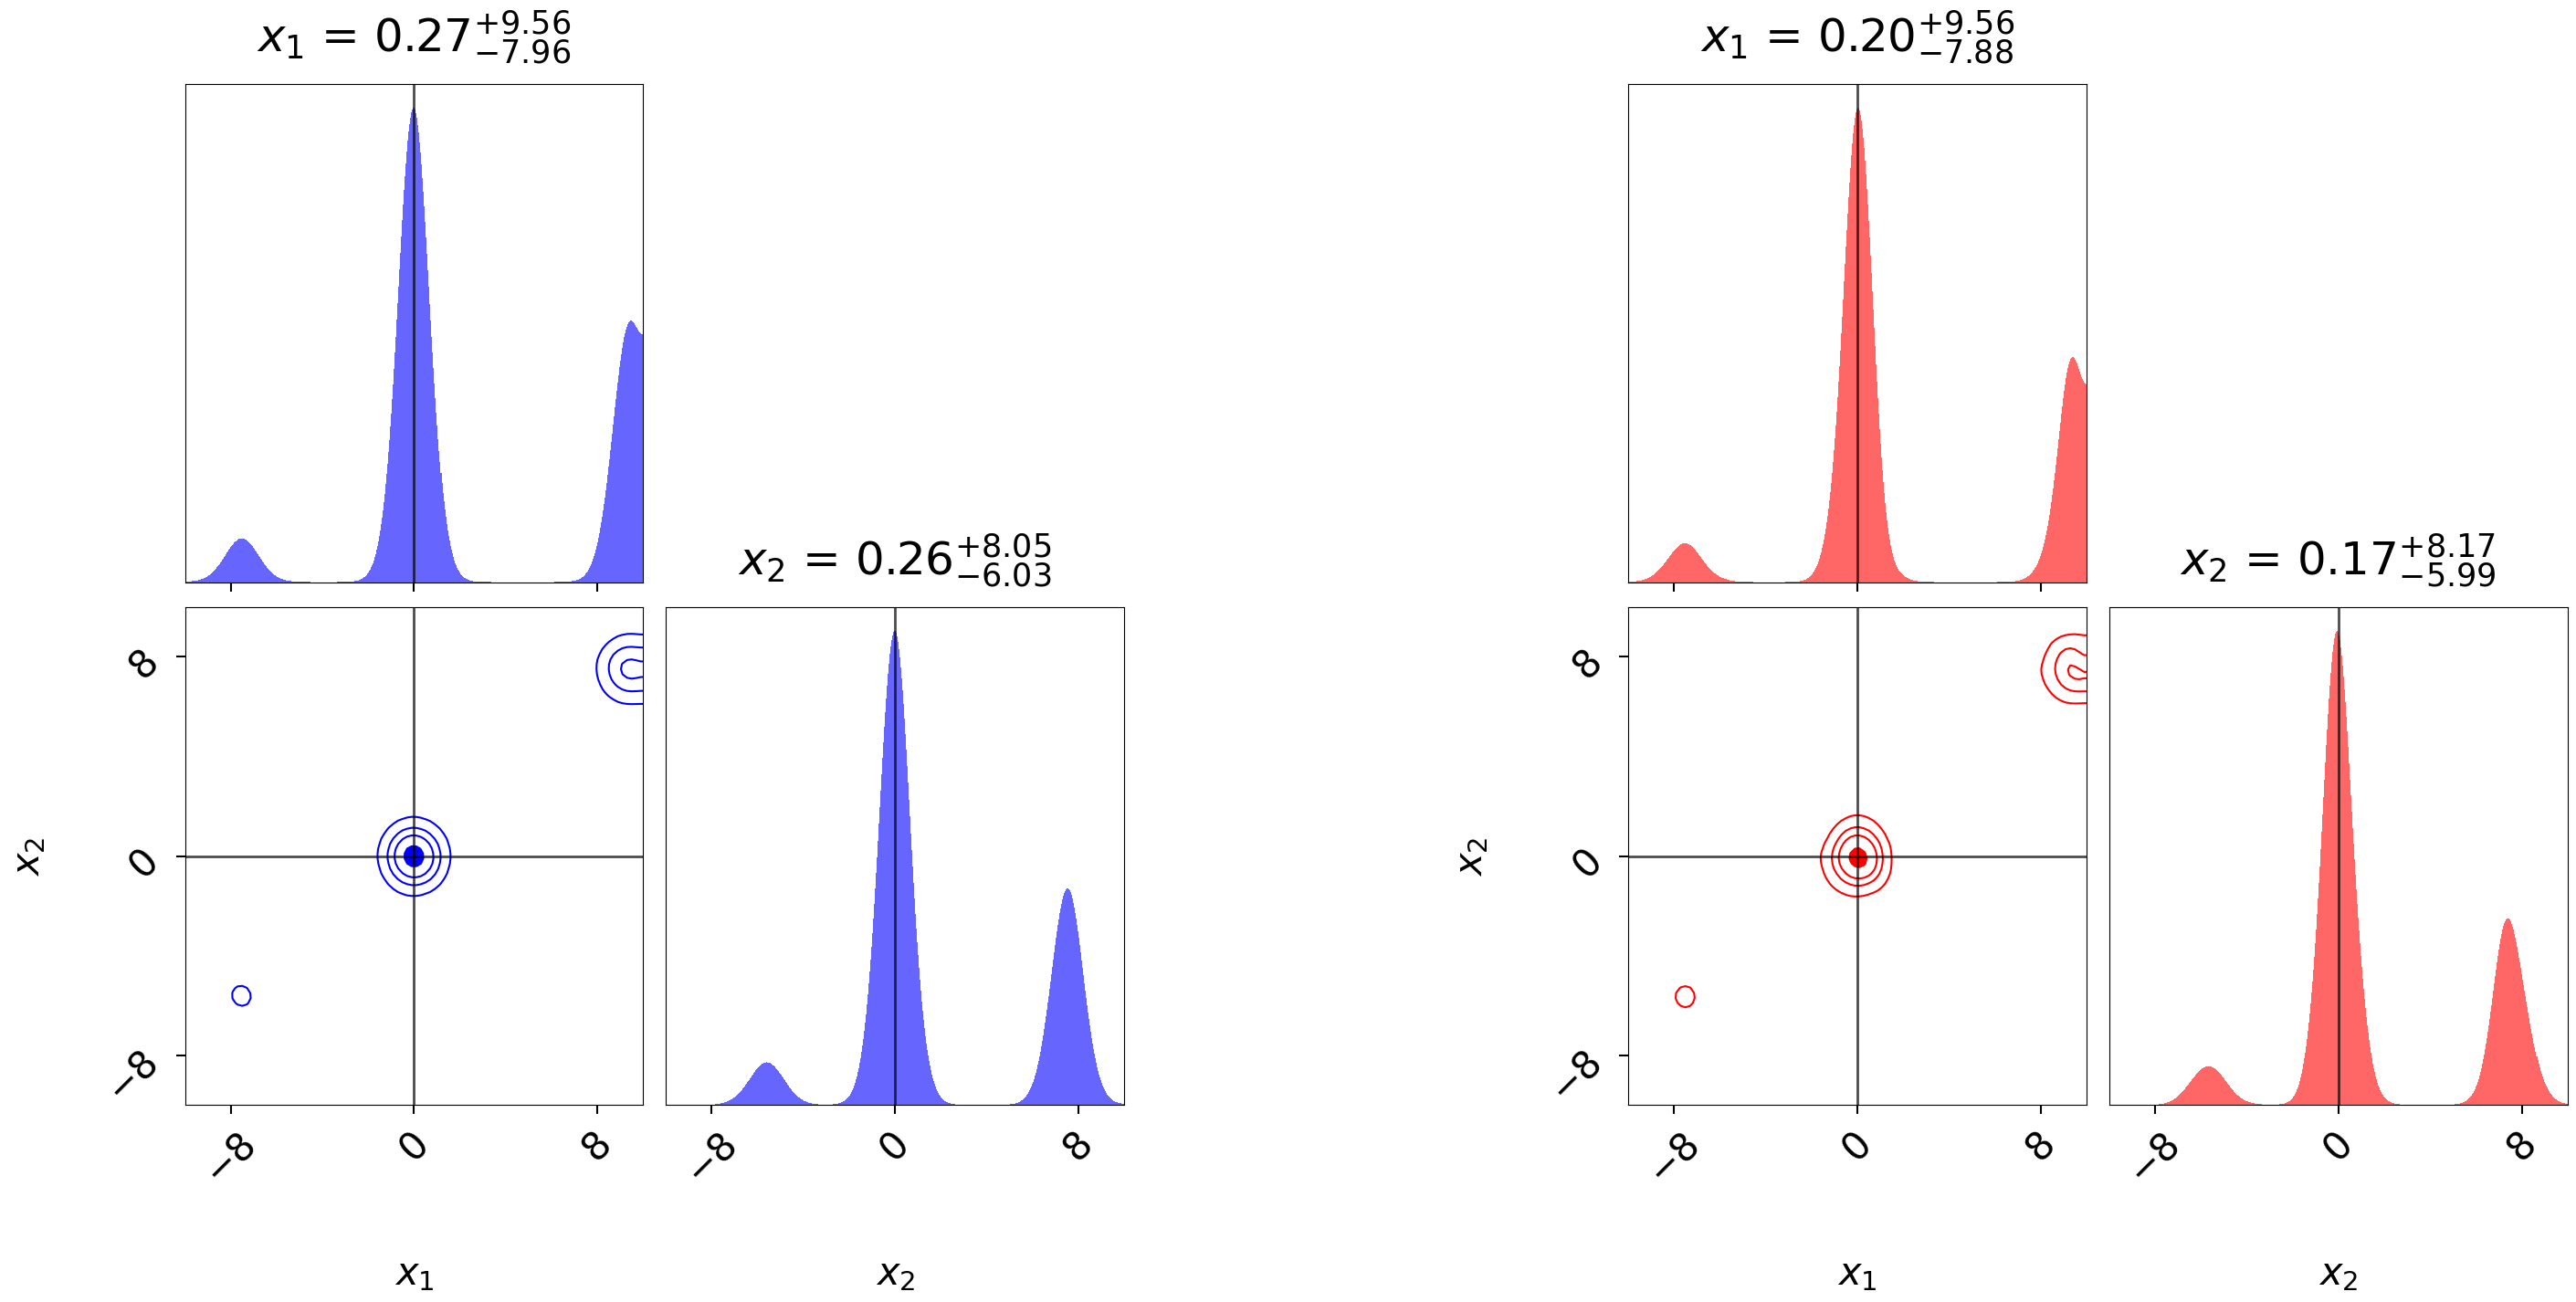

In [44]:
# initialize figure
fig, axes = plt.subplots(2, 5, figsize=(35, 15))
axes = axes.reshape((2, 5))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]

# plot noiseless run (left)
fg, ax = dyplot.cornerplot(dres, color='blue', truths=[0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05},
                           quantiles=None, fig=(fig, axes[:, :2]))

# plot reweighted noisy run (right)
fg, ax = dyplot.cornerplot(dres2_rwt, color='red', truths=[0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 3:]))

In [52]:
dyplot.cornerplot?

Signature:
dyplot.cornerplot(
    results,
    dims=None,
    span=None,
    quantiles=(0.025, 0.5, 0.975),
    color='black',
    smooth=0.02,
    quantiles_2d=None,
    hist_kwargs=None,
    hist2d_kwargs=None,
    labels=None,
    label_kwargs=None,
    show_titles=False,
    title_quantiles=(0.025, 0.5, 0.975),
    title_fmt='.2f',
    title_kwargs=None,
    truths=None,
    truth_color='red',
    truth_kwargs=None,
    max_n_ticks=5,
    top_ticks=False,
    use_math_text=False,
    verbose=False,
    fig=None,
)
Docstring:
Generate a corner plot of the 1-D and 2-D marginalized posteriors.

Parameters
----------
results : :class:`~dynesty.results.Results` instance
    A :class:`~dynesty.results.Results` instance from a nested
    sampling run. **Compatible with results derived from**
    `nestle <http://kylebarbary.com/nestle/>`_.

dims : iterable of shape (ndim,), optional
    The subset of dimensions that should be plotted. If not provided,
    all dimensions will be shown.

spa

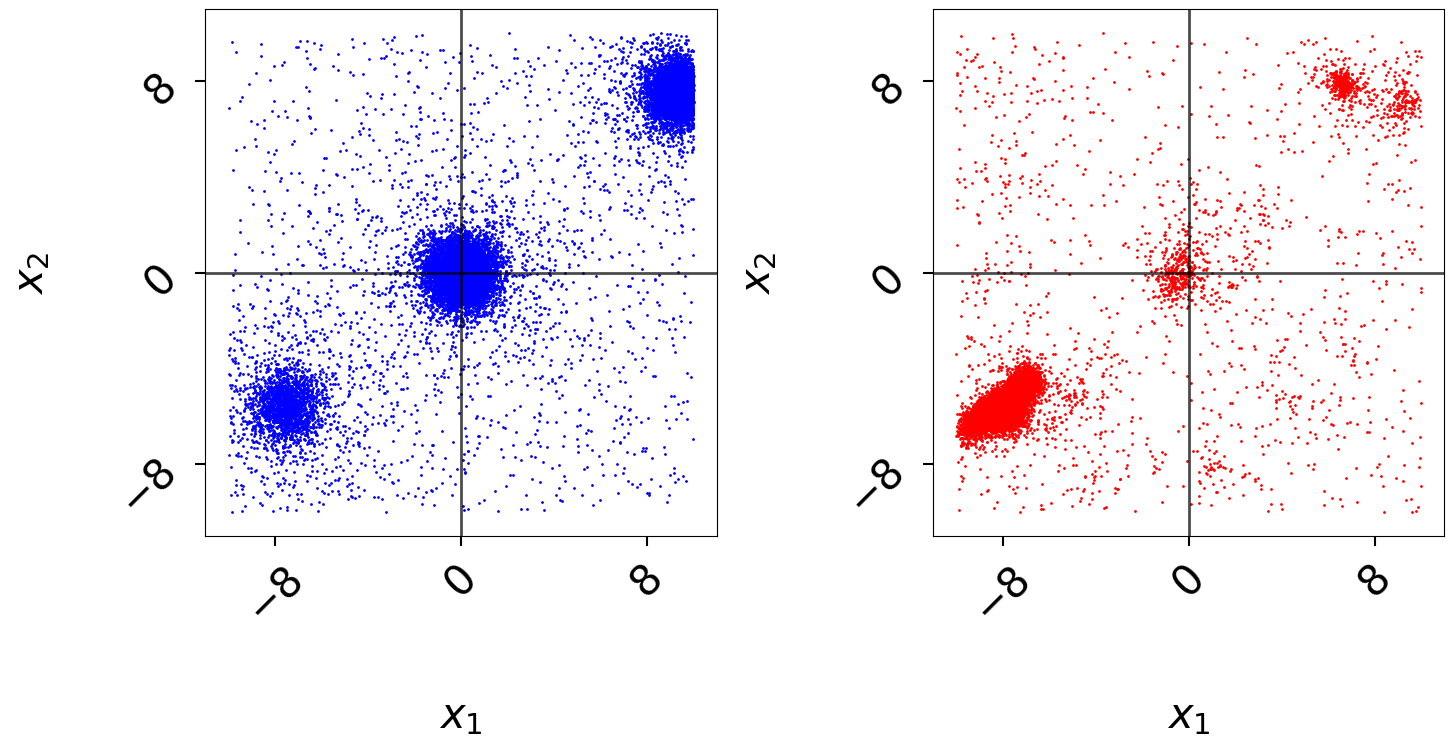

In [66]:
# initialize figure
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# plot noiseless run (left)
fg, ax = dyplot.cornerpoints(dres, color='blue', truths=[0., 0.], truth_color='black',
                           max_n_ticks=3, fig=(fig, axes[0]))

# plot realization of reweighted run (right)
logl_t = rstate.normal(logls_est, logls_std)
dres2_rwt2 = dynesty.utils.reweight_run(dres2, logp_new=logl_t)
fg, ax = dyplot.cornerpoints(dres2_rwt2, color='red', truths=[0., 0.], truth_color='black', max_n_ticks=3, fig=(fig, axes[1]))
plt.tight_layout()

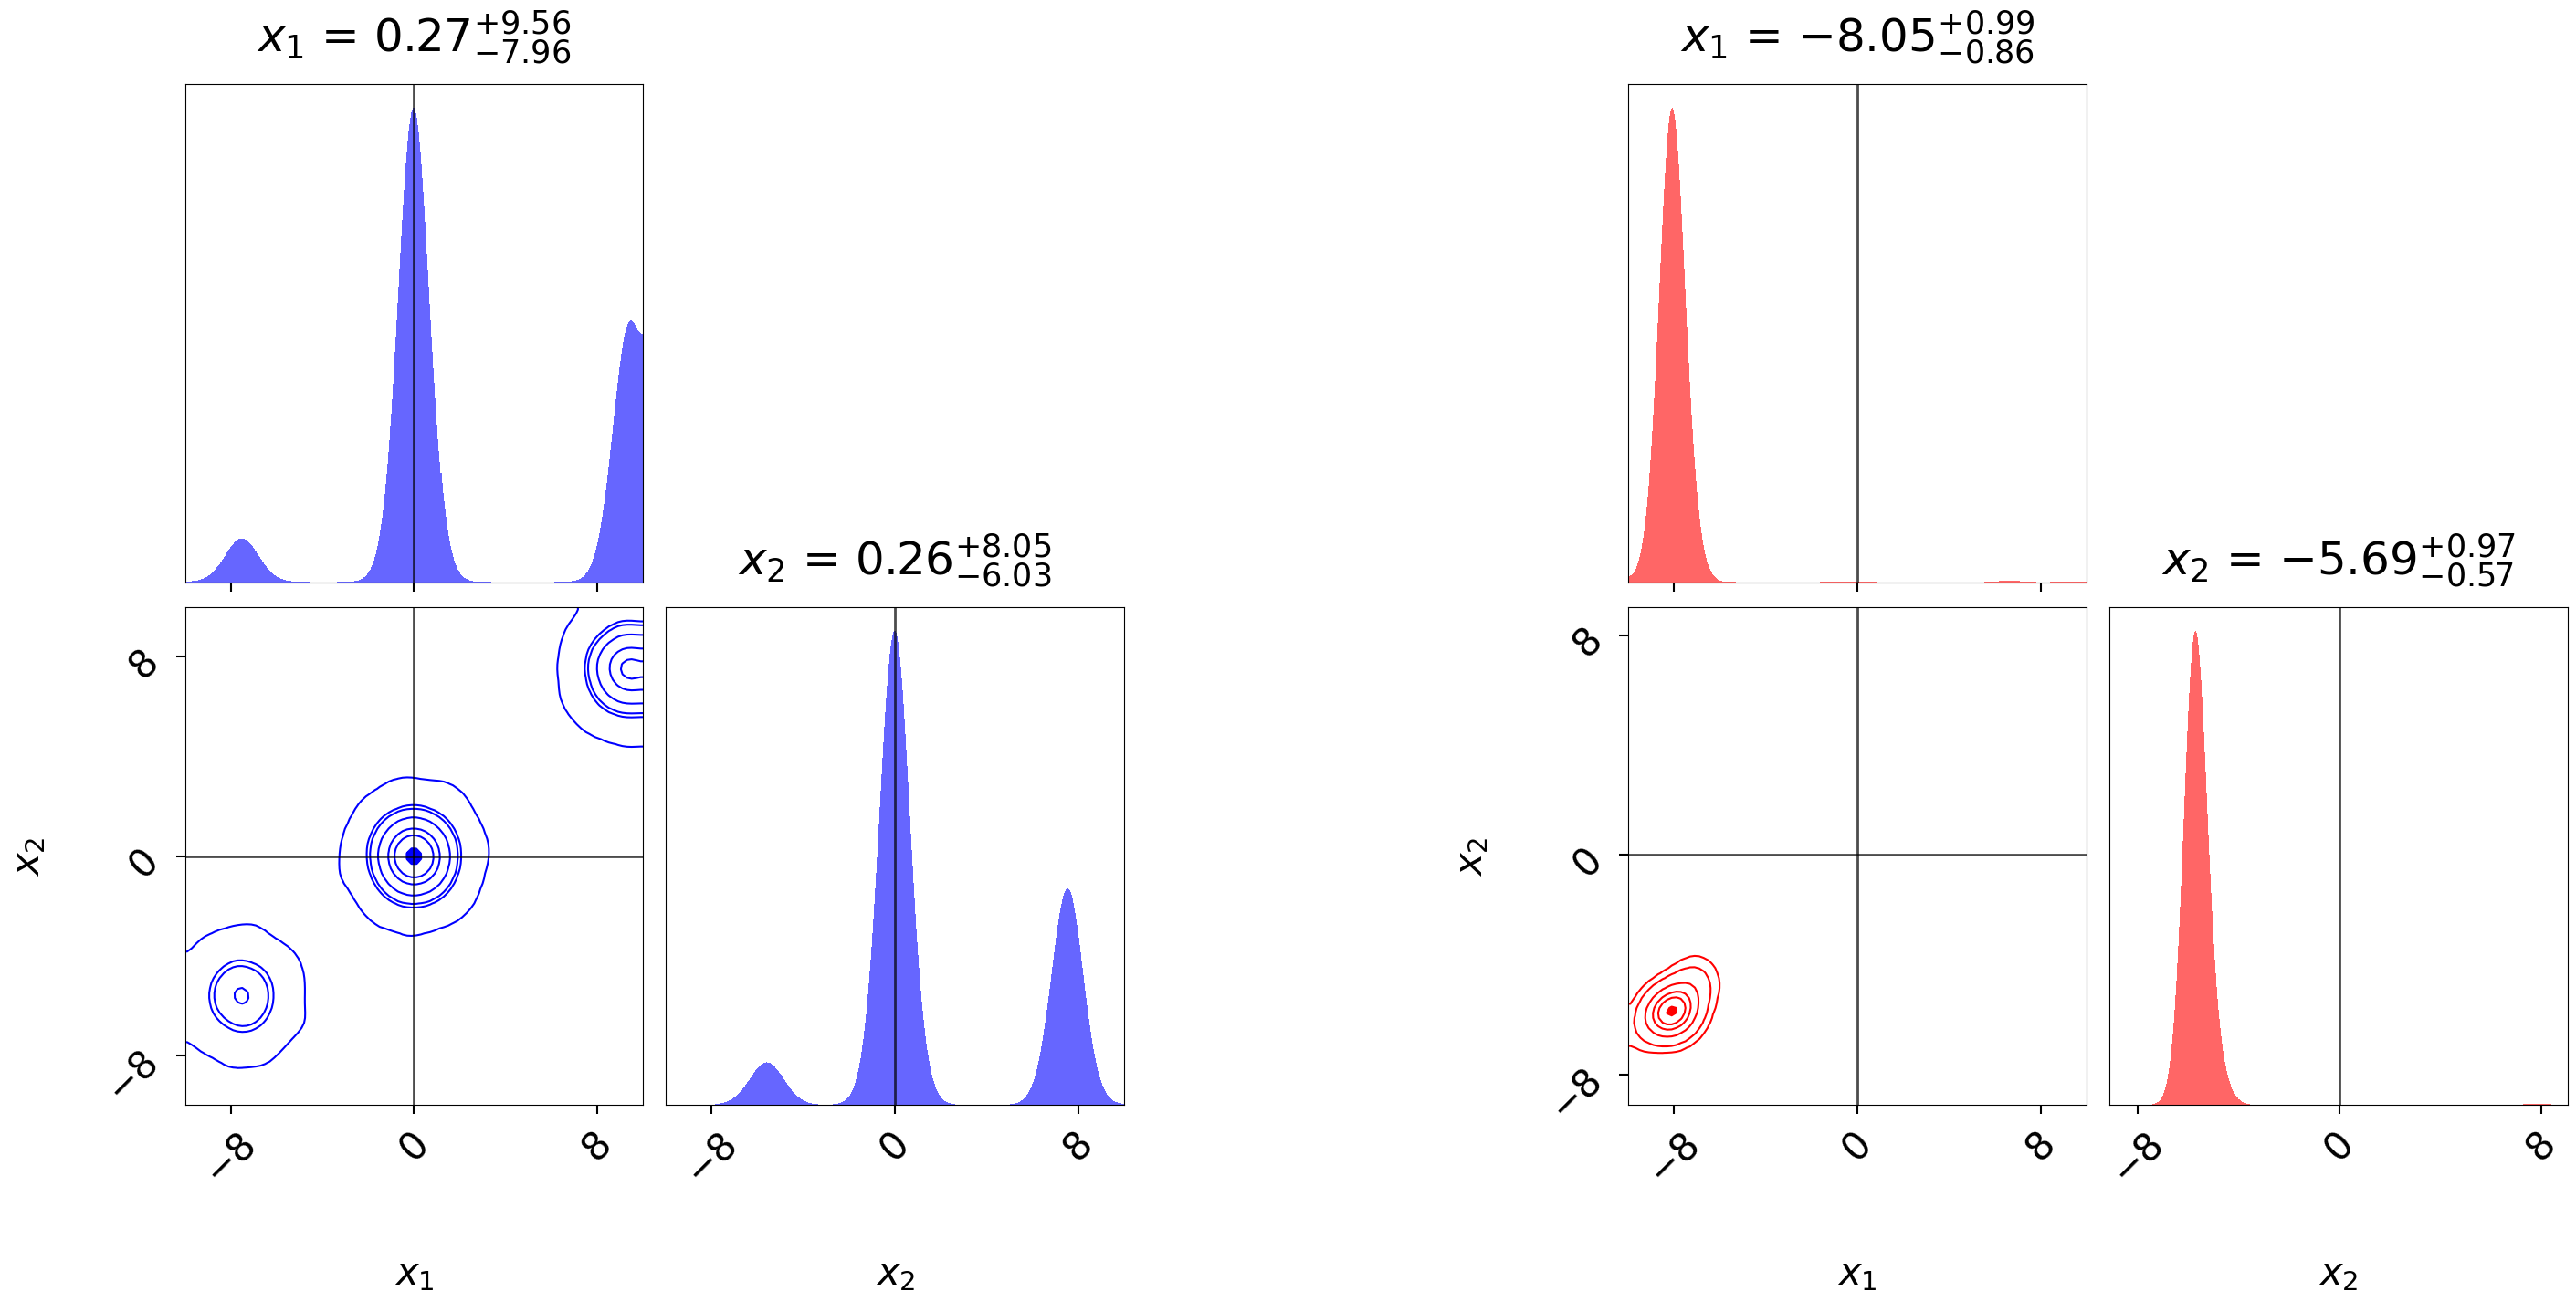

In [56]:
# initialize figure
fig, axes = plt.subplots(2, 5, figsize=(35, 15))
axes = axes.reshape((2, 5))
[a.set_frame_on(False) for a in axes[:, 2]]
[a.set_xticks([]) for a in axes[:, 2]]
[a.set_yticks([]) for a in axes[:, 2]]

# plot noiseless run (left)
fg, ax = dyplot.cornerplot(dres, color='blue', truths=[0., 0.], truth_color='black',
                           show_titles=True, max_n_ticks=3, title_kwargs={'y': 1.05}, quantiles_2d=[0.1, 0.4, 0.65, 0.85, 0.95, 0.97, 0.999],
                           quantiles=None, fig=(fig, axes[:, :2]))

# plot realization of reweighted run (right)
logl_t = rstate.normal(logls_est, logls_std)
dres2_rwt2 = dynesty.utils.reweight_run(dres2, logp_new=logl_t)
fg, ax = dyplot.cornerplot(dres2_rwt2, color='red', truths=[0., 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},  quantiles_2d=[0.1, 0.4, 0.65, 0.85, 0.97, 0.99],
                           quantiles=None, max_n_ticks=3, fig=(fig, axes[:, 3:]))